# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [3]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/zx/46y7zv8x5gd6xfp0s16kr0w00000gp/T/pip-req-build-eqiknrg9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/zx/46y7zv8x5gd6xfp0s16kr0w00000gp/T/pip-req-build-eqiknrg9
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [4]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.4.0


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [6]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [7]:
model, preprocess = clip.load("ViT-B/32")
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [9]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x144e79da0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [11]:
clip.tokenize("one two three")

tensor([[49406,   637,  1237,  2097, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [13]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import urllib.request
from collections import OrderedDict
import torch
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [15]:
def loadImage(url, rows=5, cols=5):
  original_images = []
  urllib.request.urlretrieve(
    url,
    "img.gif")
  im = Image.open("img.gif")
  try:
    while 1:
      im.seek(im.tell()+1)
      original_images.append(im.convert("RGB"))
  except EOFError:
    pass

  print(len(original_images))

  processed_images = []

  for image in original_images:
    processed_images.append(preprocess(image))

  plt.figure(figsize=(20, 10))
  start = 0
  for i in range(rows*cols):
    plt.subplot(rows, cols, i+1)
    plt.imshow(original_images[start+i])
    plt.axis('off')
    #plt.title(str(start+i))
  plt.tight_layout()
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

  return original_images, processed_images



## Renaming Files (Data Collection)

In [17]:
import os
# print(sorted(os.listdir("./gifs"), key = lambda x: int(x.split(".")[0]))[-1].split(".")[0])

In [18]:
import os

def rename_files_in_folder(folder_path, start_value, file_extension):
    files = sorted(os.listdir(folder_path))
    for i, filename in enumerate(files):
        if filename == ".DS_Store":
            continue
        new_name = f"{start_value + i}.{file_extension}"
        old_file = os.path.join(folder_path, filename)
        new_file = os.path.join(folder_path, new_name)
        os.rename(old_file, new_file)
        print(f"Renamed {filename} to {new_name}")

# Example usage:
# folder_path = '../GIFS'
# start_value = int(sorted(os.listdir("./gifs"), key = lambda x: int(x.split(".")[0]))[-1].split(".")[0]) + 1
# file_extension = 'gif'
# rename_files_in_folder(folder_path, start_value, file_extension)


In [19]:
from PIL import Image
import matplotlib.pyplot as plt

def loadImageLocal(local_path, rows=5, cols=5):
    original_images = []

    im = Image.open(local_path)
    
    try:
        im.seek(im.tell())
        original_images.append(im.convert("RGB"))
        while 1:
            im.seek(im.tell()+1)
            original_images.append(im.convert("RGB"))
    except EOFError:
        pass

    print(len(original_images))

    processed_images = []

    for image in original_images:
        processed_images.append(preprocess(image))

    # plt.figure(figsize=(20, 10))
    # start = 0
    # for i in range(rows*cols):
    #     plt.subplot(rows, cols, i+1)
    #     plt.imshow(original_images[start+i])
    #     plt.axis('off')
    #     plt.title(str(start+i))
    # plt.tight_layout()
    # plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

    return original_images, processed_images


In [20]:
a,b=loadImageLocal("gifs/14.gif", 5, 5)

37


In [21]:
def findMatch(original_images, processed_images, texts):
  t1 = time.perf_counter()
  image_input = torch.tensor(np.stack(processed_images))
  text_tokens = clip.tokenize(["This is " + desc for desc in texts])

  with torch.no_grad():
      image_features = model.encode_image(image_input).float()
      text_features = model.encode_text(text_tokens).float()

  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
  t2 = time.perf_counter()
  print('time (sec) taken to run:',t2-t1)

  #print(similarity)
  plt.figure(figsize=(18, 6*len(texts)))
  for i, text in enumerate(texts):
    plt.subplot(len(texts),2,1+2*i)
    plt.plot(range(len(similarity[i])), similarity[i])
    plt.title("best match is: "+ str(np.argmax(similarity[i])), fontdict={'fontsize': 40})
    plt.subplot(len(texts),2,2+2*i)
    plt.imshow(original_images[np.argmax(similarity[i])])
    plt.title(text, fontdict={'fontsize': 40})
  plt.tight_layout()

In [22]:
from PIL import Image, ImageTk
import tkinter as tk

def showFrames(path):
    gif_path = path
    gif = Image.open(gif_path)
    
    root = tk.Tk()
    root.title("Picking Best Frame")
    
    frame_number = 0
    frames = []
    while True:
        try:
            gif.seek(frame_number)
            frame = gif.copy()
            frames.append(frame)
            frame_number += 1
        except EOFError:
            break
    
    def display_frame(index):
        frame_label.config(text=f"Frame {index}")
        img = ImageTk.PhotoImage(frames[index])
        frame_canvas.create_image(0, 0, anchor=tk.NW, image=img)
        frame_canvas.image = img
    
    frame_label = tk.Label(root, text="Frame 0", font=('Typo Round', 14))
    frame_label.pack()
    
    frame_canvas = tk.Canvas(root, width=frames[0].width, height=frames[0].height)
    frame_canvas.pack()
    
    display_frame(0)
    
    def next_frame(event):
        current_frame = int(frame_label.cget("text").split()[1])
        next_index = (current_frame + 1) % len(frames)
        display_frame(next_index)
    def prev_frame(event):
        current_frame = int(frame_label.cget("text").split()[1])
        next_index = (current_frame - 1) % len(frames)
        display_frame(next_index)
    
    root.bind('<Right>', next_frame)
    root.bind('<Left>', prev_frame)
    
    root.mainloop()


15
time (sec) taken to run: 0.4797943339217454


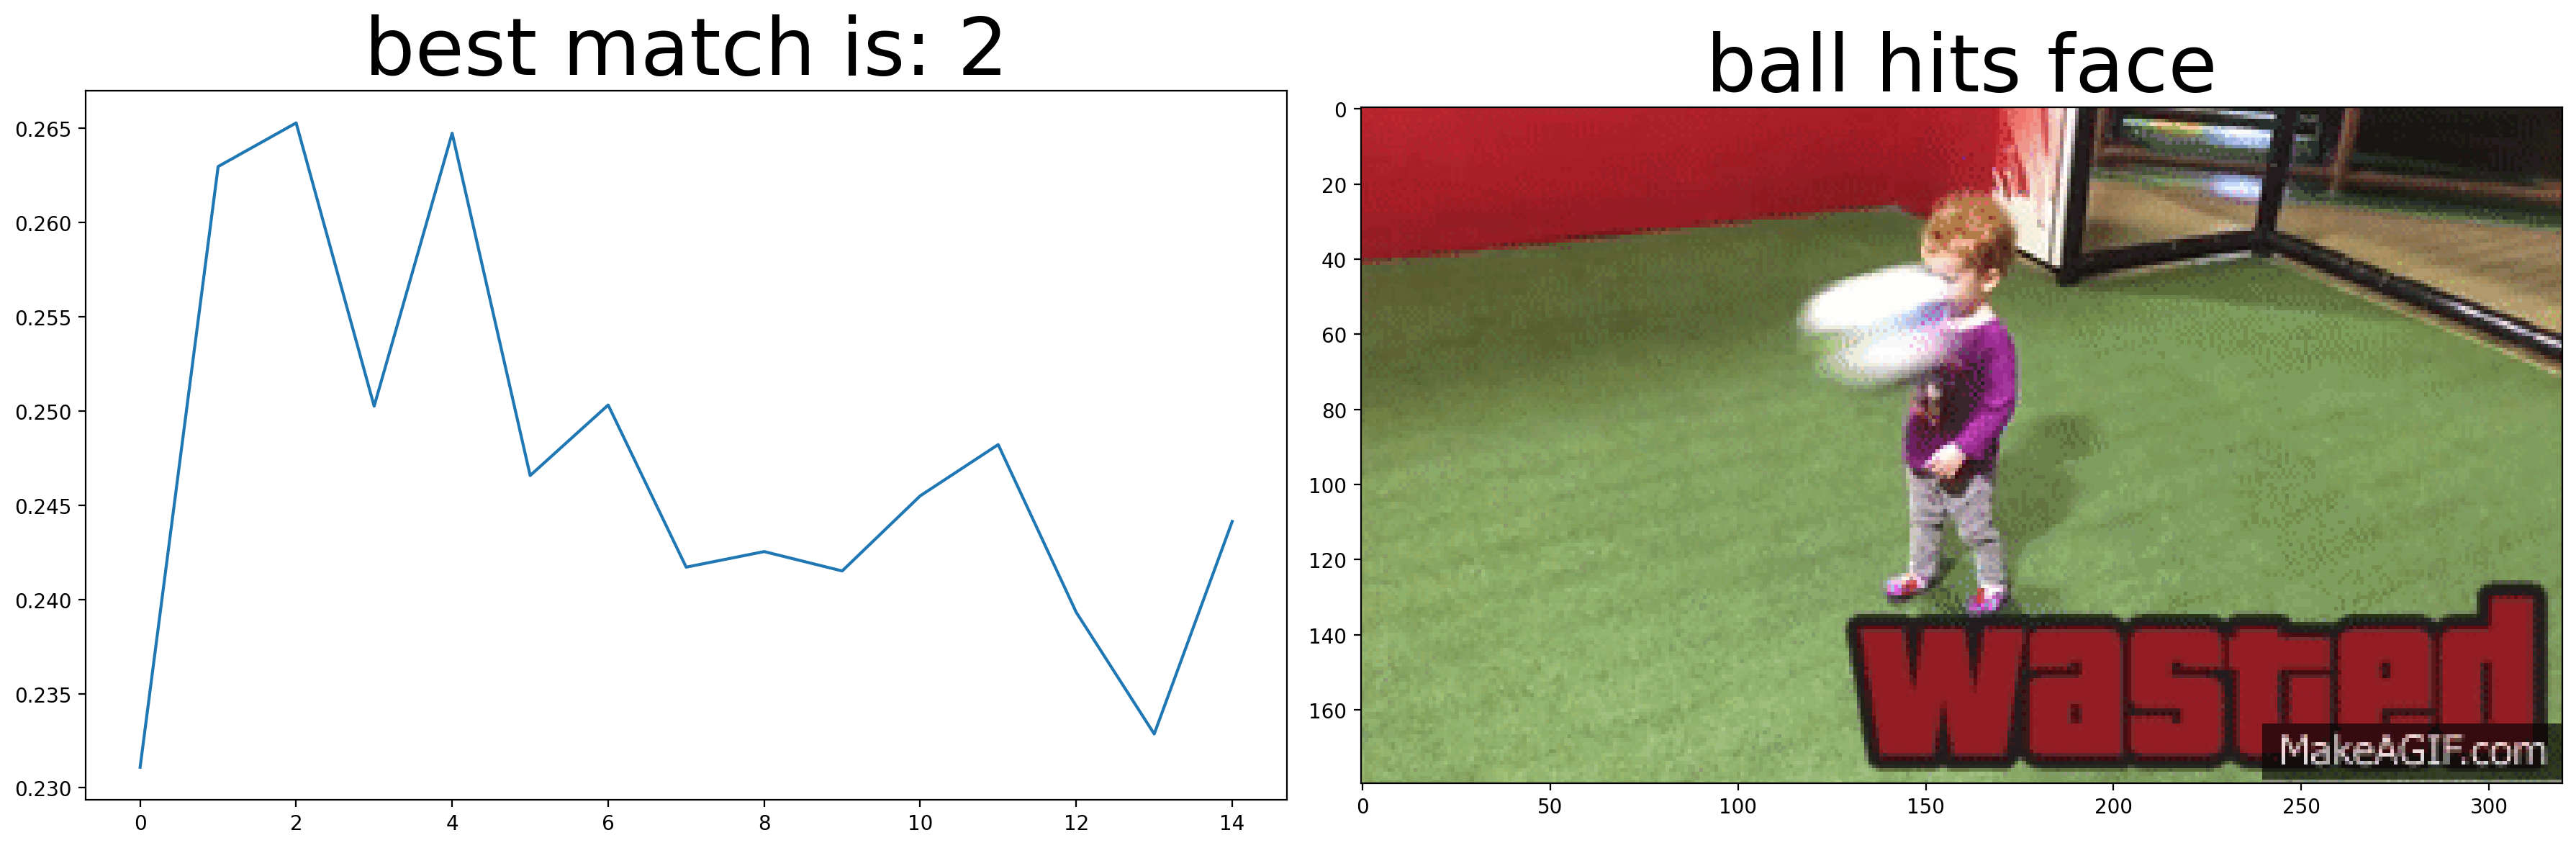

In [56]:
GIF = 'gifs/87.gif'
texts = ["ball hits face"]
orig_imgs, proc_imgs = loadImageLocal(GIF)
findMatch(orig_imgs, proc_imgs, texts)

# Loading Data from `photo_data.csv`

In [115]:
import pandas as pd
import math
photo_data_csv = pd.read_csv("photo_data.csv")
photo_data_csv.head()

,Id,Description,Correct Frame,Unnamed: 3,Unnamed: 4,Gifs Completed,Unnamed: 6,Unnamed: 7,Frequency
0,1.0,woman falls down,19.0,NaN,NaN,1,1.0,True,2
1,2.0,woman falls down,9.0,NaN,NaN,2,2.0,True,1
2,3.0,guy falls down onto couch,28.0,NaN,NaN,3,3.0,True,2
3,4.0,person falls down,14.0,NaN,NaN,4,4.0,True,1
4,5.0,guy falls down,10.0,NaN,NaN,5,5.0,True,1


In [143]:
all_labeled_data = photo_data_csv.iloc[:, :3]

unfiltered_data_triples = list(all_labeled_data.itertuples(index=False, name=None))

labeled_data_float = list(filter(lambda x: not math.isnan(x[0]), unfiltered_data_triples))

labeled_data = list(map(lambda x: (f'gifs/{int(x[0])}.png', x[1], int(x[2])), labeled_data_float))

labeled_data

[('gifs/1.png', 'woman falls down', 19),
 ('gifs/2.png', 'woman falls down', 9),
 ('gifs/3.png', 'guy falls down onto couch', 28),
 ('gifs/4.png', 'person falls down', 14),
 ('gifs/5.png', 'guy falls down', 10),
 ('gifs/6.png', 'guy falls onto ground', 29),
 ('gifs/7.png', 'a small kid falls down', 22),
 ('gifs/8.png', 'a dog catching a frisbee in mouth', 67),
 ('gifs/8.png', 'a dog catch frisbee in mouth', 67),
 ('gifs/8.png', 'a dog with frisbee in mouth', 67),
 ('gifs/8.png', 'a dog catching a frisbee in its mouth', 67),
 ('gifs/11.png', 'guy throws tennis racket', 35),
 ('gifs/11.png', 'guy throws tennis racquet', 35),
 ('gifs/11.png', 'guy throwing tennis racquet', 35),
 ('gifs/11.png', 'guy throwing tennis racket', 35),
 ('gifs/12.png', 'guy hitting tennis ball with racket', 10),
 ('gifs/12.png', 'guy hits tennis ball with racket', 10),
 ('gifs/12.png', 'tennis racket hits ball', 10),
 ('gifs/12.png', 'guy hits ball with tennis racket', 10),
 ('gifs/13.png', 'guy falls down', 10)

In [109]:
ids

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 8.0,
 8.0,
 8.0,
 11.0,
 11.0,
 11.0,
 11.0,
 12.0,
 12.0,
 12.0,
 12.0,
 13.0,
 14.0,
 14.0,
 14.0,
 15.0,
 13.0,
 15.0,
 16.0,
 7.0,
 1.0,
 16.0,
 16.0,
 3.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 19.0,
 19.0,
 19.0,
 19.0,
 20.0,
 20.0,
 20.0,
 21.0,
 21.0,
 21.0,
 21.0,
 22.0,
 22.0,
 22.0,
 22.0,
 22.0,
 25.0,
 25.0,
 35.0,
 26.0,
 26.0,
 27.0,
 27.0,
 28.0,
 28.0,
 29.0,
 29.0,
 30.0,
 38.0,
 38.0,
 30.0,
 39.0,
 39.0,
 31.0,
 39.0,
 39.0,
 9.0,
 23.0,
 9.0,
 9.0,
 9.0,
 10.0,
 10.0,
 10.0,
 10.0,
 24.0,
 23.0,
 24.0,
 24.0,
 24.0,
 33.0,
 32.0,
 34.0,
 34.0,
 36.0,
 37.0,
 36.0,
 36.0,
 36.0,
 37.0,
 63.0,
 63.0,
 40.0,
 42.0,
 42.0,
 41.0,
 42.0,
 42.0,
 41.0,
 43.0,
 43.0,
 45.0,
 44.0,
 44.0,
 46.0,
 46.0,
 45.0,
 45.0,
 45.0,
 48.0,
 47.0,
 47.0,
 48.0,
 49.0,
 49.0,
 49.0,
 50.0,
 51.0,
 52.0,
 51.0,
 52.0,
 51.0,
 53.0,
 53.0,
 54.0,
 53.0,
 54.0,
 53.0,
 55.0,
 56.0,
 56.0,
 55

In [99]:
float('nan')

nan

In [103]:
list(filter(lambda x: x != ,photo_data_csv['Id'].tolist()))

[1.0, 2.0, 3.0, 4.0, 1.0, 3.0]